In [22]:
import pdb
import sys
import argparse
import numpy as np

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.losses import MeanSquaredError

%matplotlib inline
import pandas as pd

PATH_TO_FIXED_POINT_FINDER = 'C:/Users/Bwa/Documents/UW/AMATH 422/fixed-point-finder/'
sys.path.insert(0, PATH_TO_FIXED_POINT_FINDER)

PATH_TO_FIXED_POINT_FINDER = 'C:/Users/Bwa/Documents/UW/AMATH 422/fixed-point-finder/src/recurrent-whisperer/'
sys.path.insert(0, PATH_TO_FIXED_POINT_FINDER)

from FixedPointFinder import FixedPointFinder
from FixedPoints import FixedPoints


import tf_utils

from importlib import reload 
import plot_utils
plot_utils = reload(plot_utils)

from plot_utils import plot_fps

In [23]:
tf.__version__

'1.14.0'

In [24]:
np.__version__

'1.19.5'

In [25]:
n_windows = 1000
n_input =  1
n_output = 1
size_train = 8001
r_neuron = 16  
random_seed = 42
rng = np.random.RandomState(random_seed)

learning_rate = 0.1

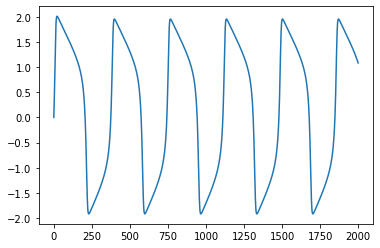

In [26]:
a = 0.7
b = 0.8
r = 0.08
I = 1

v_init = 0
w_init = 0

#nsteps = 10000
dt = 0.1

n = int(1/dt)
n_time=n_windows
Tmax = n_time*n +1
v = np.zeros([Tmax])
w = np.zeros([Tmax])
t = np.zeros([Tmax])

v[0] = v_init
w[0] = w_init
t[0] = 0.0

for step in np.arange(Tmax-1):
    for bit_index in np.arange(n_input):
        v[step+1] = v[step] + (v[step]- ((v[step])**3) /3 -w[step] + I)*dt
        w[step+1] = w[step] + ((v[step] +a - b*w[step]) * r)*dt
        t[step+1] = t[step] + dt

plt.plot(v[0:2000])
plt.show()

In [27]:
series = np.array(v.copy())

In [28]:
## Split data
train = series[:size_train]
test = series[size_train:]

In [29]:
def create_batches(df, windows, input, output):
    ## Create X         
        x_data = train[:size_train-1] # Select the data
        X_batches = x_data.reshape(-1, windows, input)  # Reshape the data 
    ## Create y
        y_data = train[output:size_train]
        y_batches = y_data.reshape(-1, windows, output)
        return X_batches, y_batches

In [30]:
X_batches, y_batches = create_batches(df = train,
                                      windows = n_windows,
                                      input = n_input,
                                      output = n_output)

In [31]:
X_test, y_test = create_batches(df = test, windows = n_windows,input = n_input, output = n_output)

In [32]:
def _np_init_weight_matrix(input_size, output_size, rng):
    if input_size == 0:
        scale = 1.0 # This avoids divide by zero error
    else:
        scale = 1.0 / np.sqrt(input_size)
    W = np.multiply(scale,rng.randn(input_size, output_size))
    b = np.zeros(output_size)
    return W, b

In [33]:
n_hidden = 16
n_batch = X_batches.shape[0]
tf.reset_default_graph()

X = tf.placeholder(tf.float32,[None, n_windows, n_input])
y = tf.placeholder(tf.float32,[None, n_windows, n_output])

rnn_cell = tf.nn.rnn_cell.LSTMCell(r_neuron)

# init = tf.global_variables_initializer()
initial_state = rnn_cell.zero_state(n_batch, dtype=tf.float32)

state_bxtxd = tf_utils.unroll_LSTM(rnn_cell,inputs=X,initial_state=initial_state)

hidden_bxtxd = state_bxtxd.h

np_W_out, np_b_out = _np_init_weight_matrix(n_hidden, n_output,rng)
W_out = tf.Variable(np_W_out, dtype=tf.float32, name='W_out')
b_out = tf.Variable(np_b_out, dtype=tf.float32, name='b_out')
y_pred_out = tf.tensordot(hidden_bxtxd,W_out, axes=1) + b_out
#optimizer = tf.keras.optimizers.Adam(clipvalue=1.0) clipnorm
loss = tf.reduce_mean(tf.squared_difference(y, y_pred_out))
step = tf.Variable(0, name='step', trainable=False)
rate = tf.train.exponential_decay(learning_rate, step, 1000, 0.9)
optimizer = tf.train.AdamOptimizer(learning_rate=rate) 
training_op = optimizer.minimize(loss,global_step=step) 

init = tf.global_variables_initializer() 

In [13]:
tf.test.is_gpu_available()

False

In [14]:
iteration = 1000

sess = tf.Session()

init.run(session=sess)
for iters in range(iteration):
    sess.run(training_op, feed_dict={X: X_batches, y: y_batches})
    if iters % 10 == 0:
        mse = loss.eval(session=sess,feed_dict={X: X_batches, y: y_batches, step:iters})
        print(iters, "\tMSE:", mse)

0 	MSE: 0.71393484
10 	MSE: 0.027705736
20 	MSE: 0.0069169635
30 	MSE: 0.0046442426
40 	MSE: 0.0012484422
50 	MSE: 0.00071734615
60 	MSE: 0.00042087125
70 	MSE: 0.00033934956
80 	MSE: 0.00025688208
90 	MSE: 0.00021860361
100 	MSE: 0.00019507183
110 	MSE: 0.00018000139
120 	MSE: 0.00016929206
130 	MSE: 0.00016092214
140 	MSE: 0.00015423706
150 	MSE: 0.00014822549
160 	MSE: 0.00014274531
170 	MSE: 0.00013760594
180 	MSE: 0.00013274142
190 	MSE: 0.00012810643
200 	MSE: 0.00012366993
210 	MSE: 0.00011940977
220 	MSE: 0.00011530909
230 	MSE: 0.000111355526
240 	MSE: 0.00010753979
250 	MSE: 0.00010385567
260 	MSE: 0.00010029879
270 	MSE: 9.686656e-05
280 	MSE: 9.355746e-05
290 	MSE: 9.037064e-05
300 	MSE: 8.730661e-05
310 	MSE: 8.436531e-05
320 	MSE: 8.1546736e-05
330 	MSE: 7.885045e-05
340 	MSE: 7.6274926e-05
350 	MSE: 7.381742e-05
360 	MSE: 7.1473776e-05
370 	MSE: 6.923905e-05
380 	MSE: 6.710699e-05
390 	MSE: 6.507109e-05
400 	MSE: 6.312488e-05
410 	MSE: 6.1262035e-05
420 	MSE: 5.9476784e-

In [15]:
y_pred,valid_states = sess.run([y_pred_out,state_bxtxd], feed_dict={X: X_test})

In [16]:
batch=6
plt.title("Forecast vs Actual", fontsize=14)
plt.plot(pd.Series(np.ravel(y_test[batch:batch+1])), "bo", markersize=3, label="Actual", color='green')
plt.plot(pd.Series(np.ravel(y_pred[batch:batch+1])), "r.", markersize=3, label="Forecast", color='red')
plt.legend(loc="lower left")
plt.xlabel("Time")
plt.show()

C:\Users\Bwa\anaconda3\envs\rnn_project\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  import sys


In [17]:
def _sample_trial_and_time_indices(valid_bxt, n, rng):
    (trial_idx, time_idx) = np.nonzero(valid_bxt)
    max_sample_index = len(trial_idx)
    sample_indices = rng.randint(max_sample_index, size=n)
    return trial_idx[sample_indices], time_idx[sample_indices]

In [34]:
NOISE_SCALE = 0.3 # Standard deviation of noise added to initial states
N_INITS = 1024 # The number of initial states to provide
n_bits = 1
is_lstm =True

session = sess

state_traj_bxtxd = tf_utils.convert_from_LSTMStateTuple(valid_states)

[n_batch, n_time, n_states] = state_traj_bxtxd.shape

valid_bxt = np.ones((n_batch, n_time), dtype=np.bool)
trial_indices, time_indices = _sample_trial_and_time_indices(valid_bxt, N_INITS, rng)

# Draw random samples from state trajectories
statesx = np.zeros([N_INITS, n_states])
for init_idx in range(N_INITS):
    trial_idx = trial_indices[init_idx]
    time_idx = time_indices[init_idx]
    statesx[init_idx,:] = state_traj_bxtxd[trial_idx, time_idx]

states = statesx + NOISE_SCALE * rng.randn(*statesx.shape)
initial_states = tf_utils.convert_to_LSTMStateTuple(states)

In [35]:
fpf_hps = {}

# Setup the fixed point finder
fpf = FixedPointFinder(rnn_cell, sess, **fpf_hps)

inputs = np.zeros([1,n_bits])

unique_fps, all_fps = fpf.find_fixed_points(initial_states, inputs)

plot_fps(unique_fps, valid_states,plot_batch_idx=list(range(30)),plot_start_time=10)


Searching for fixed points from 1024 initial states.

	Finding fixed points via joint optimization.


ValueError: Fetch argument <tf.Operation 'init_1' type=NoOp> cannot be interpreted as a Tensor. (Operation name: "init_1"
op: "NoOp"
input: "^Variable/Assign"
 is not an element of this graph.)